In [14]:
import sys
sys.path.append('waveglow/')

import numpy as np
import torch
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

from hparams import create_hparams
from model import Tacotron2
from train import load_model, load_checkpoint
from text import text_to_sequence
from audio_processing import griffin_lim
from layers import TacotronSTFT

In [15]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [16]:
hparams = create_hparams()

## Load model from training checkpoint

In [17]:
# tacotron2
iteration = 1900
checkpoint_path = './training/cantonese/checkpoint_{}'.format(iteration)
model = load_model(hparams)
model, _, _, _ = load_checkpoint(checkpoint_path, model)
_ = model.cuda().eval()#.half()

Loading checkpoint './training/cantonese/checkpoint_1900'
Loaded checkpoint './training/cantonese/checkpoint_1900' from iteration 1900


In [5]:
# waveglow
waveglow_path = './pretrain_model/waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
_ = waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()

/home/lokhiufung/miniconda3/envs/pytorch-1.3/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/lokhiufung/miniconda3/envs/pytorch-1.3/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


## Prepare text input

In [46]:
text = "人口變化正正在消費需求嘅焦點"
sequence = np.array(text_to_sequence(text, ['transliteration_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence).cuda().long())

In [47]:
print(sequence)

tensor([[55, 42, 51, 11, 48, 52, 58, 11, 39, 46, 38, 51, 11, 45, 58, 38, 11, 63,
         45, 42, 51, 44, 11, 63, 45, 42, 51, 44, 11, 63, 38, 46, 11, 61, 46, 38,
         52, 11, 43, 42, 46, 11, 61, 58, 11, 54, 46, 58, 11, 48, 38, 46, 11, 47,
         46, 38, 52, 11, 41, 46, 38, 51, 11]], device='cuda:0')


## Synthesize audio from spectrogram

In [33]:
# load test data
from data_utils import TextMelLoader
from text import sequence_to_text

In [26]:
test_path = '/home/lokhiufung/data/cantonese/test_tacotron2.txt'
text_mel_loader = TextMelLoader(test_path, hparams)
sequence, mel = text_mel_loader[0]
print(sequence_to_text(sequence.data.cpu().numpy()))
sequence = sequence.unsqueeze(0).cuda().long()
# text = sequence_to_text(sequence)  # convert a sequence of IDs back to a string

you ji 


Warning! Reached max decoder steps


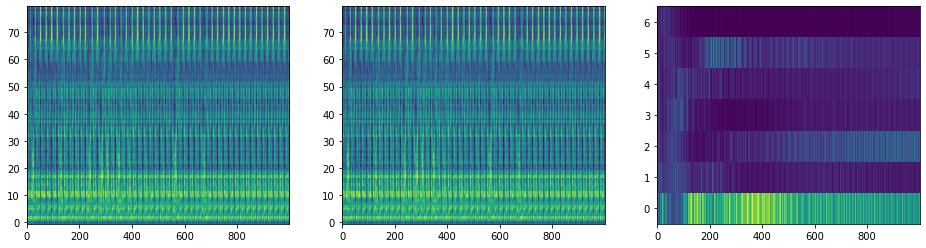

In [27]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [60]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

Warning! Reached max decoder steps


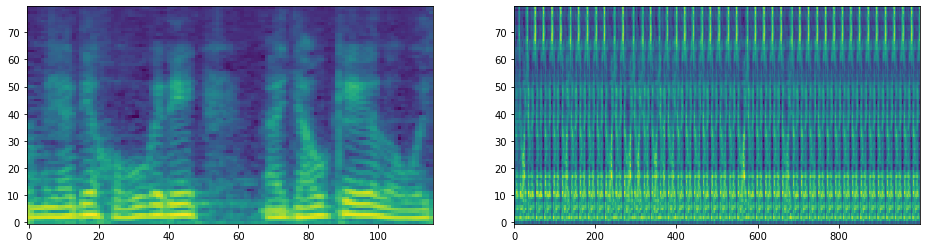

In [28]:
# target mel spectrogram vs predicted spectrogram
plot_data([mel, mel_outputs_postnet.float().data.cpu().numpy()[0]])

In [39]:
# explore data
ipd.Audio(text_mel_loader.audiopaths_and_text[0][0])

### WaveGlow

In [10]:
with torch.no_grad():
#     audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
    audio = waveglow.infer(mel.unsqueeze(0).cuda().half(), sigma=0.666)
    
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

/home/lokhiufung/miniconda3/envs/pytorch-1.3/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/lokhiufung/miniconda3/envs/pytorch-1.3/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/lokhiufung/miniconda3/envs/pytorch-1.3/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/lokhiufung/miniconda3/envs/pytorch-1.3/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use t

### Griffin-Lim 

from: https://github.com/NVIDIA/tacotron2/issues/201

In [29]:
griffin_iters = 60

taco_stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, sampling_rate=hparams.sampling_rate)
mel_decompress = taco_stft.spectral_de_normalize(mel_outputs_postnet)
mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
spec_from_mel_scaling = 1000
spec_from_mel = torch.mm(mel_decompress[0], taco_stft.mel_basis)
spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
spec_from_mel = spec_from_mel * spec_from_mel_scaling

audio = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), taco_stft.stft_fn, griffin_iters)

audio = audio.squeeze()
audio = audio.cpu().numpy()

In [30]:
from scipy.io.wavfile import write
write('test.wav', hparams.sampling_rate, audio)